In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
wuhan = pd.read_excel("https://github.com/c2-d2/COVID-19-wuhan-guangzhou-data/raw/master/seriouscase_share.xlsx", sheet_name='Wuhan', index_col="Confirmed date")

In [9]:
source = wuhan
df = wuhan[['now confirmed', 'new confirmed', 'critical', 'new dead', 'new cured']]
df.columns = ['current', 'new','critical', 'dead', 'recovered'] # In light of recent evidence, we call it discharged rather than cured

In [10]:
df = df.fillna(method='ffill').fillna(0)
df = df.assign(
    cum_recovered=df.recovered.cumsum() + source['cured'].iloc[0],
    cum_dead=df.dead.cumsum() + source['dead'].iloc[0],
    cum_confirmed=df.new.cumsum() + source['tot confirmed'].iloc[0],
) # Use running sums instead of reported numbers, numbers are low.

# Problem statement 

We believe that there is a high chance that the duration of hospital stays that are being used in models like [CMMID's Hospital Bed Occcupancy Projections](https://cmmid-lshtm.shinyapps.io/hospital_bed_occupancy_projections/) are based on incorrect distributional assumptions informed by poor experimental design, misleading data, or an anomalous result early on in the epidemic in a paper by [Zhou et. al.](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext).


We use the dataset curated by [Ruoran, Li et. al.](https://dash.harvard.edu/handle/1/42599304) for their paper in order to do some empirical analysis of hospital stay distributions.

In Wuhan, there were 3215 cases by the end of this study (1-31-20), of which only 198 had been confirmed 12 days earlier (the stated median time of of hospital stay).
The paper reports the median time to death was 4 days faster than the time to recovery, and in most cases the best guess for the mean is the sample median 
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1097734/)

Under these assumptions, if we forward 8 and 12 days from 1-19 at the deaths and recoveries respectively, you'd expect them to be somewhat proportional to the CFR, unless one is substantially more long tailed.


In [14]:
death_check = pd.Timestamp('1-19-20') + pd.Timedelta(days=8)
recovery_check = pd.Timestamp('1-19-20') + pd.Timedelta(days=12)

# At this time, all cases were hospitalized
df.loc[death_check, 'cum_dead'], df.loc[recovery_check, 'cum_recovered']
# Instead, we find that deaths and recoveries are somewhat proportional.

(86.0, 110.0)

In [15]:
# Find a distribution that vaguely fits the Zhou paper for stay length in deaths (median 8 IQR (4-12)):
pd.Series(np.random.negative_binomial(2.8, .24, 1000000)).describe()

count    1000000.000000
mean           8.874497
std            6.094610
min            0.000000
25%            4.000000
50%            8.000000
75%           12.000000
max           69.000000
dtype: float64

Assume a mean of a 9 day stay for deaths, based on the distribution above, derived from the Zhou et. al's median and IQR. 
The death lengths are more likely to be accurate than the potentially censored recovery length of stay
though it is also the case that some of these cases were likely severe before they were counted!

## Warning:
The below should likely be implemented via Bayesian regression and use a more complex model as opposed to just implementing a 1d grid search, so results could be inaccurate

We conduct a grid search over possible stay lengths using later data than the study, as there are more cases and less chance for stochastic error.

Additionally, we suspect that the data anomaly on 2-12-20 skews results substantially, so we do not start until after this date.

We assume a 20% hospitalization rate after 02-12-20, similar to New York


In [21]:
corrected = df.loc['02-13-20':]

mean_error = np.zeros(30)
for i in range(30):
    mean_error[i] = np.power((np.power((
        corrected.cum_confirmed * .2 -
        corrected.cum_recovered.shift(-i) * .2 -
        corrected.cum_dead.shift(-9))/(corrected.cum_confirmed * .2 -corrected.cum_dead.shift(-9)),
    2).mean()), .5)
np.argsort(mean_error)[:5], mean_error[np.argsort(mean_error)][:5]

(array([16, 15, 14, 13, 12]),
 array([0.28124077, 0.32857845, 0.37494668, 0.42903518, 0.47660051]))

This suggests that the data would best fit a 15+ day mean recovery time. The paper cites a median of 12 days and IQR of (9 - 15) days for non-icu patients.

The estimated value is stable over date ranges (aft. Even if we charitably assume that there is only a 5% hospitalization rate, and that 20% of those found recovered were hospital patients, this only drops to 14. If hospitalization rates were higher, it could be as high as a mean of 17 days.

Given only 8% of survivors went to the ICU in the paper (though this could again be censoring), we expect the overall mean stay length for those who recover to be around 14-15.

We try to fit a distribution to the cited median and the estimated mean below (through sensitivity analysis):

In [23]:
print(pd.Series(np.random.gamma(1.4, 15/1.4, 1000000)).describe(),
pd.Series(16.5*np.random.weibull(1.3, 1000000)).describe(),
pd.Series(np.random.negative_binomial(1.7, .1, 1000000)).describe(),
pd.Series(np.random.exponential(15, 1000000)).describe())

count    1000000.000000
mean          14.985501
std           12.670420
min            0.000288
25%            5.769531
50%           11.606147
75%           20.566450
max          152.786104
dtype: float64 count    1000000.000000
mean          15.250039
std           11.846188
min            0.000132
25%            6.323303
50%           12.457042
75%           21.216474
max          112.587417
dtype: float64 count    1000000.000000
mean          15.305990
std           12.367548
min            0.000000
25%            6.000000
50%           12.000000
75%           21.000000
max          150.000000
dtype: float64 count    1000000.000000
mean          14.969810
std           14.994012
min            0.000016
25%            4.293965
50%           10.368724
75%           20.759596
max          229.188407
dtype: float64


In [24]:
# Trying a compound distribution!
bimodal = pd.Series(np.concatenate([np.random.gamma(20, 12/20, 80000), np.random.gamma(1.5, 16/1.5, 100000)]))
print(bimodal.describe())

count    180000.000000
mean         14.223404
std          10.110455
min           0.001246
25%           8.911565
50%          12.008876
75%          16.046423
max         136.708218
dtype: float64


None of the simple distributions seem to fit the provided IQR. 
There are a few possibilities: 
1. The study is incorrectly designed, and doesn't account for the time in which a person was in another hospital before being transferred, or doesn't account for patients who have longer stays skewing the distribution
2. The population that had the virus early on in the study was somehow different than the general population that was infected later.
3. The data from Wuhan was manipulated in some way, including at later dates.
4. The criteria for hospital admission or testing changed substantially over time, biasing results.

The multimodal/compound distribution (if correct) could result from different populations having different recovery times - the study could be including the people with comorbitities that died and the people who are very healthy and recovered quickly enough, but not the other two members of the matrix (who had too long of a recovery time to be included in the study).

A fourth possibility could also be screwing up the statistics, though it would result in a mean lower than the median, and is unlikely early on:

- China was expelling people once they hit a certain time limit, cutting off the tail of a distribution (or counting them as so artificially and moving them to another location). This may be a practical reality for many countries, where severe patients may need to be put in quarantine before they are fully recovered so as to triage new patients (once overflow occurs).


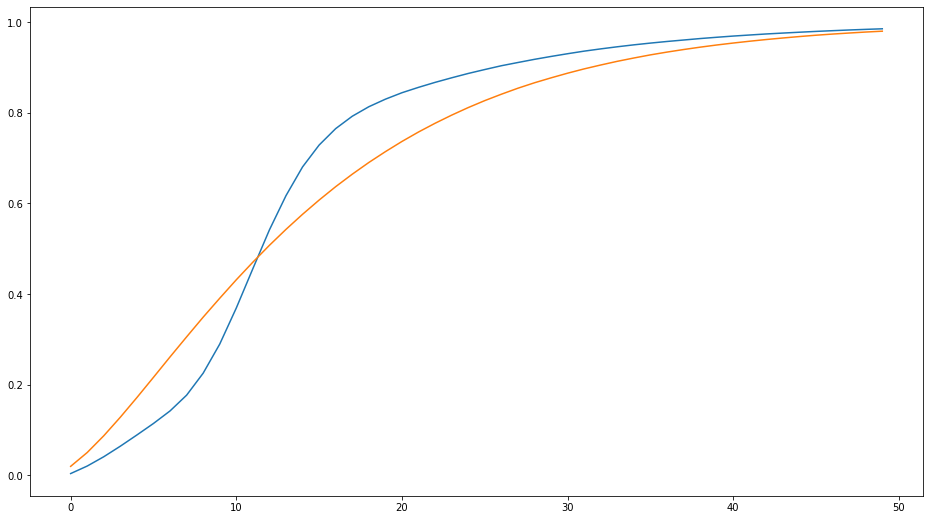

In [28]:
pd.Series((np.bincount(np.round(bimodal).astype(int))/len(bimodal)).cumsum())[:50].plot(figsize=(16, 9))
pd.Series((np.bincount(np.random.negative_binomial(1.7, .1, 1000000))/1000000).cumsum())[:50].plot()

The compound gamma distribution is likely to result in less long term patients than the negative binomial 
Lets compare this to just a distribution fitted on the median and IQR 9-12-15, and also a distribution that has the same shape as the fitted ICU distribution but a higher mean

In [29]:
pd.Series(np.random.negative_binomial(18, .6, 1000000)).describe(), pd.Series(np.random.negative_binomial(4.8, .24, 1000000)).describe()

(count    1000000.000000
 mean          12.001620
 std            4.476232
 min            0.000000
 25%            9.000000
 50%           12.000000
 75%           15.000000
 max           44.000000
 dtype: float64,
 count    1000000.000000
 mean          15.205873
 std            7.962354
 min            0.000000
 25%            9.000000
 50%           14.000000
 75%           20.000000
 max           92.000000
 dtype: float64)

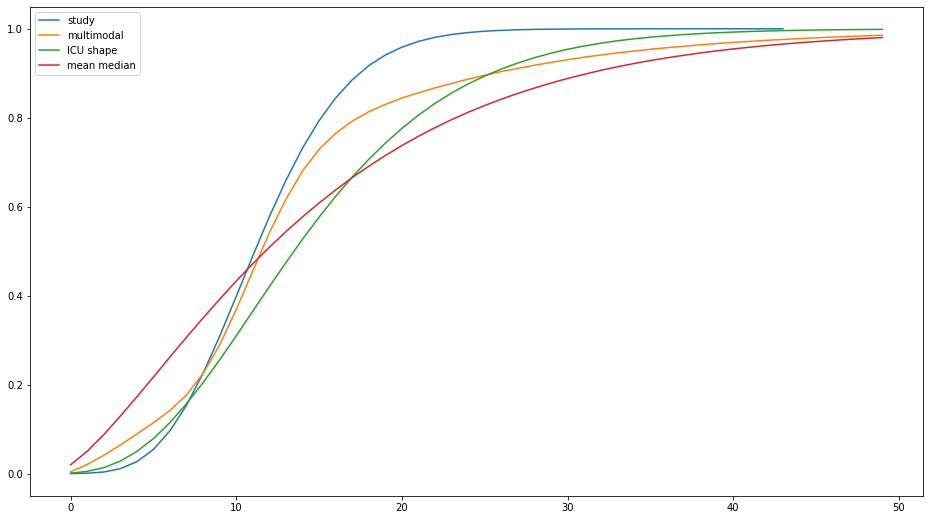

In [30]:
pd.Series((np.bincount(np.random.negative_binomial(18, .6, 1000000))/1000000).cumsum(), name='study')[:50].plot(figsize=(16, 9), legend=True)
pd.Series((np.bincount(np.round(bimodal).astype(int))/len(bimodal)).cumsum(), name='multimodal')[:50].plot(legend=True)
pd.Series((np.bincount(np.random.negative_binomial(4.8, .24, 1000000))/1000000).cumsum(), name='ICU shape')[:50].plot(legend=True)
pd.Series((np.bincount(np.random.negative_binomial(1.7, .1, 1000000))/1000000).cumsum(), name='mean median')[:50].plot(legend=True)

In [31]:
empirical = pd.Series(np.random.negative_binomial(4.8, .24, 1000000))
study = pd.Series(np.random.negative_binomial(18, .6, 1000000))
empirical.sum()/study.sum()

1.2666322971023574

If these distributional assumptions hold, this means that the number of hospital days is likely 25% higher than the amount computed by using the study.

However, if a policy is enacting of sending semi-healthy patients are home after 2 weeks, for example (we assume that 80% of patient's symptoms who have not been discharged are manageable enough after 2 weeks, and an additional 80% of those remaining can go home after three weeks):

In [32]:
tail_e = empirical[(empirical >= 14) & (empirical < 21)]
tailtail_e = empirical[empirical >= 21]
                    
healthy_e = pd.concat([
    empirical[empirical < 14],
    tail_e[:int(len(tail_e) * .2)],
    tailtail_e[:int(len(tailtail_e) * .2)]
], axis=0)
tail_s = study[(study >= 14) & (study < 21)]
tailtail_s = study[study >= 21]

healthy_s = pd.concat([
    study[study < 14],
    tail_s[:int(len(tail_s) * .2)],
    tailtail_s[:int(len(tailtail_s) * .2)]
], axis=0)

healthy_e.sum()/healthy_s.sum()

0.8602908908066068

This would mean that the mean hospital load could be ~15% lighter than expected under an early release policy (or up to 20% lighter if the empirical distribution actually does have the reported median).

## Conclusion

We conclude that it is likely that the distributions over hospital stay length from Zhou et. al. is unlikely to hold for the general population.

We believe that there is an urgent need for a better clinical dataset about outcomes and patient hospital stay durations (especially split by demographic in addition to outcome). Further, information about the tails of these distributions could help inform policy - are the patients who have extremely long stays stable? Is the ICU stay duration derived from this study also incorrect?

In cases where overflow is not expected due to current modeling, this new information could result in an expectation that overflow would occur, leading to better preparation.

In cases where overflow is already happening or expected to occur, knowledge of the probable distributional properties of hospital stays could help inform policies to prevent general ward overflow, though ICU overflow and ventilator shortage will likely still be a critical issue.